<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Augmentation/Analysis" data-toc-modified-id="Data-Augmentation/Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation/Analysis</a></span></li><li><span><a href="#Dataloader-creation-and-test" data-toc-modified-id="Dataloader-creation-and-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader creation and test</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-Testing" data-toc-modified-id="Model-Testing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Testing</a></span></li></ul></li></ul></div>

**GET DATA**

Summary of this notebook: ...

Definition of Done: ...

# Imports


In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from pprint import pprint
import tqdm

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import PReLU

sys.path.append("/home/satyarth934/code/FDL_2020/training_scripts")
import utils
import BaseAE_hurricane as aeh

# Check to see if GPU is being used
print(tensorflow.test.gpu_device_name())
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [7]:
# DATA_PATH = "/home/satyarth934/data/nasa_impact/hurricanes/*/*"
DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed_gap_filled/*"
# DATA_PATH = "/home/satyarth934/data/proxy_data/UCMerced_LandUse/Images/*/*"

MODEL_NAME = "baseAE_median_localRandom_in_swatch"
OUTPUT_MODEL_PATH = "/home/satyarth934/code/FDL_2020/Models/" + MODEL_NAME

# If custom functions were created while training. Check the load_model function
# to check if the correct model and custom objects are being imported
CUSTOM_OBJECTS = True

dims = (448, 448, 3)
    
# Dataloader creation and test
img_paths = glob.glob(DATA_PATH)
print("len(img_paths):", len(img_paths))

train_split = 0.6
valid_split = 0.2
test_split = 0.2
X_train_paths = img_paths[:int(train_split * len(img_paths))]
X_valid_paths = img_paths[int(train_split * len(img_paths)):int((train_split + valid_split) * len(img_paths))]
X_test_paths = img_paths[len(img_paths) - int(test_split * len(img_paths)):]

len(img_paths): 5345


In [8]:
print(X_test_paths[191])
print(OUTPUT_MODEL_PATH)

/home/satyarth934/data/nasa_impact/hurricanes/ep142019/ep142019_advTime_20190919T060000_goesTime_20190919T072505_intensity_55kts.png
/home/satyarth934/code/FDL_2020/Models/baseAE_hurricane_try3_ssimms


In [ ]:
if CUSTOM_OBJECTS:
    complete_model = load_model(OUTPUT_MODEL_PATH, custom_objects={'ssim_loss_ms':aeh.ssim_loss_ms})
else:
    complete_model = load_model(OUTPUT_MODEL_PATH)

for i in range(10):
#     index = np.random.randint(0, len(X_test_paths))
    img_orig = resize(plt.imread(X_test_paths[i])[:,:,:3], dims)
#     img_orig = np.load(X_test_paths[index])
    X_test_im = np.expand_dims(img_orig, 0)
    print(X_test_im.shape)
    
    out_image = np.squeeze(complete_model.predict(X_test_im))
    print("out_image ", np.min(out_image), np.max(out_image))
    
    im_min = out_image.min(axis=(0, 1), keepdims=True)
    im_max = out_image.max(axis=(0, 1), keepdims=True)
    out_image = (out_image - im_min) / (im_max - im_min)

    print("Orig ", np.min(X_test_im), np.max(X_test_im))
    print("Gen ", np.min(out_image), np.max(out_image))
    fig = plt.figure(figsize=(30, 60))
    plt.subplot(1, 3, 1)
    plt.xlabel("Original")
    plt.imshow(np.squeeze(X_test_im))
    plt.subplot(1, 3, 2)
    plt.xlabel("Reconstructed")
    plt.imshow(out_image)
    plt.savefig("reconstructed/%s/%d.png"%(MODEL_NAME, i))
    plt.savefig("reconstructed/%s/%d.eps"%(MODEL_NAME, i))
    plt.show()

**<h1>Plotting multiple models for comparison</h1>**

len(img_paths): 5345
(1, 448, 448, 3)
Orig  0.051496822 0.9238066
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


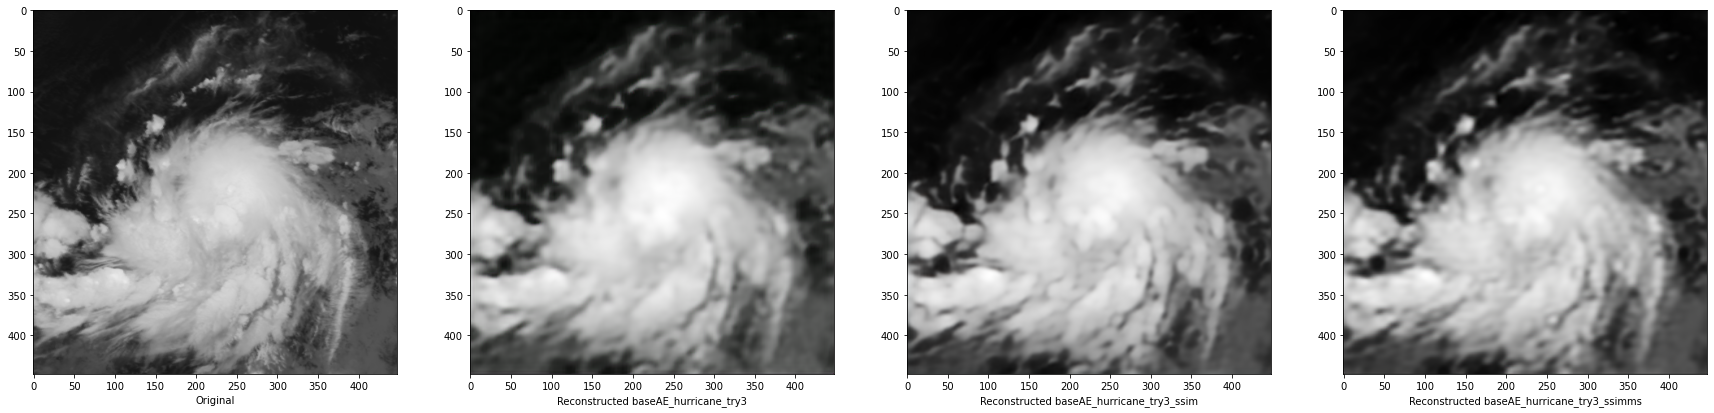

(1, 448, 448, 3)
Orig  0.020213597 0.7736262
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


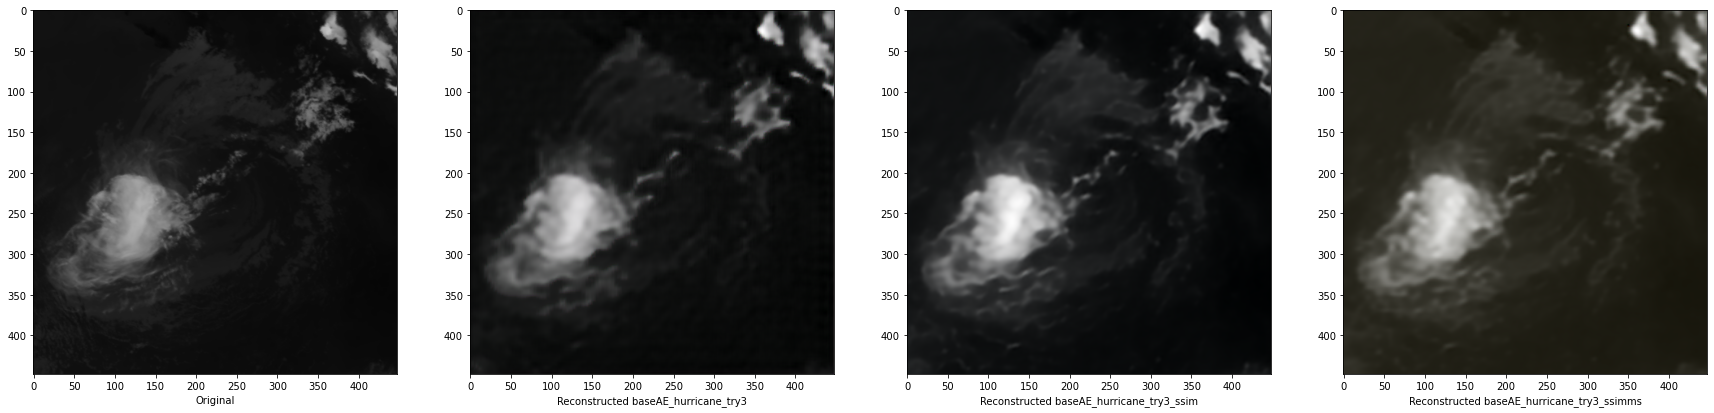

(1, 448, 448, 3)
Orig  0.08235294 0.90831125
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


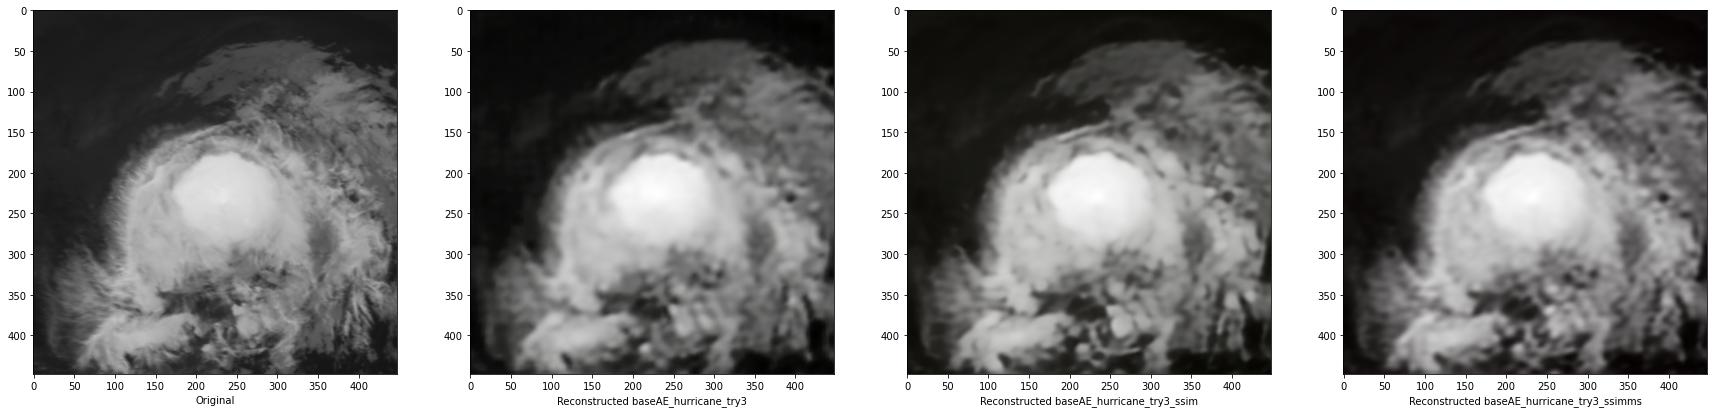

(1, 448, 448, 3)
Orig  0.039215688 0.89086473
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


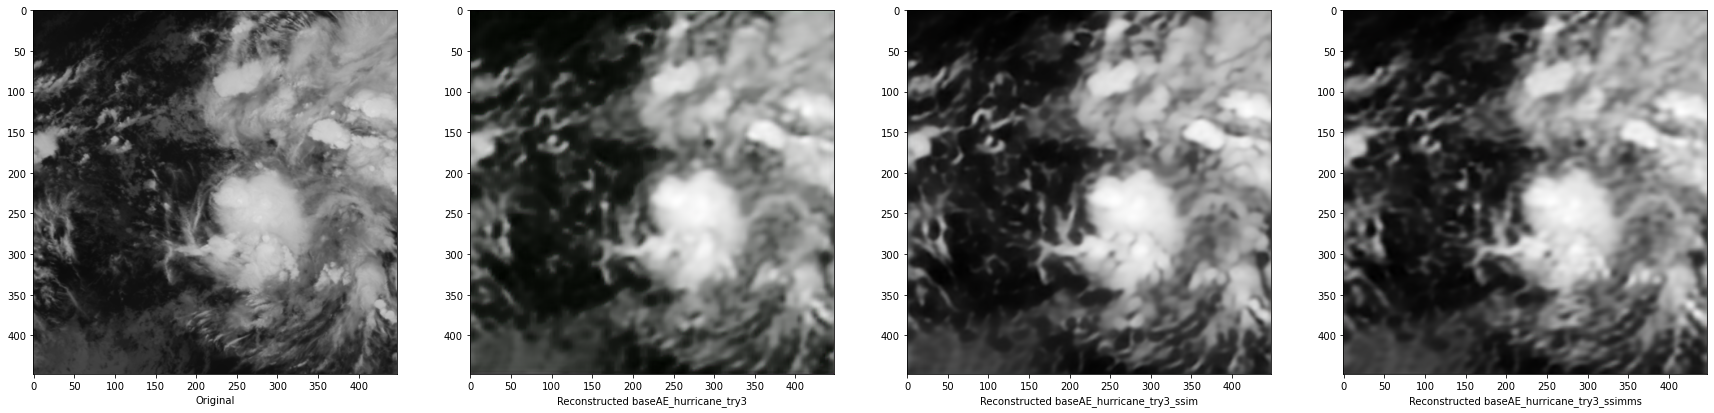

(1, 448, 448, 3)
Orig  0.20852132 0.5815616
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


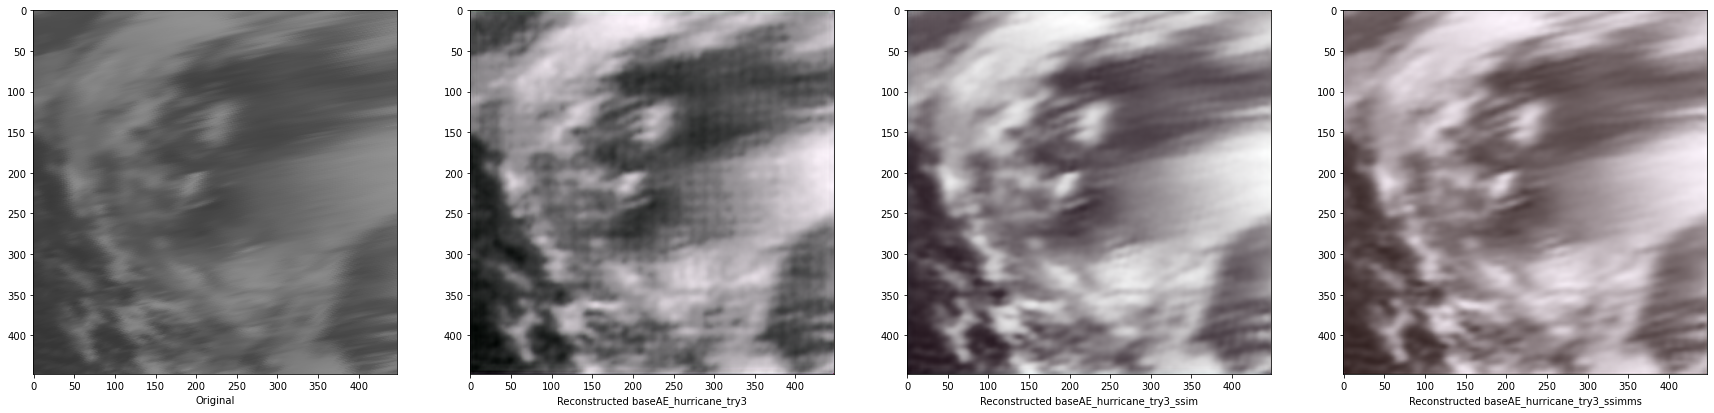

(1, 448, 448, 3)
Orig  0.043137256 0.8783777
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


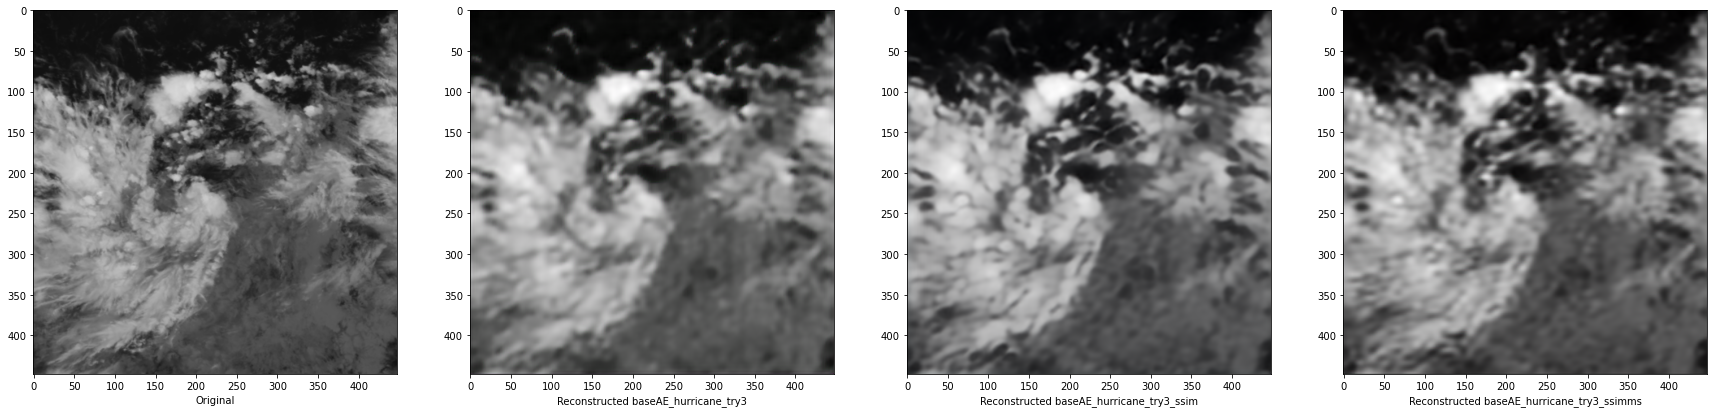

(1, 448, 448, 3)
Orig  0.023529412 0.96711665
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


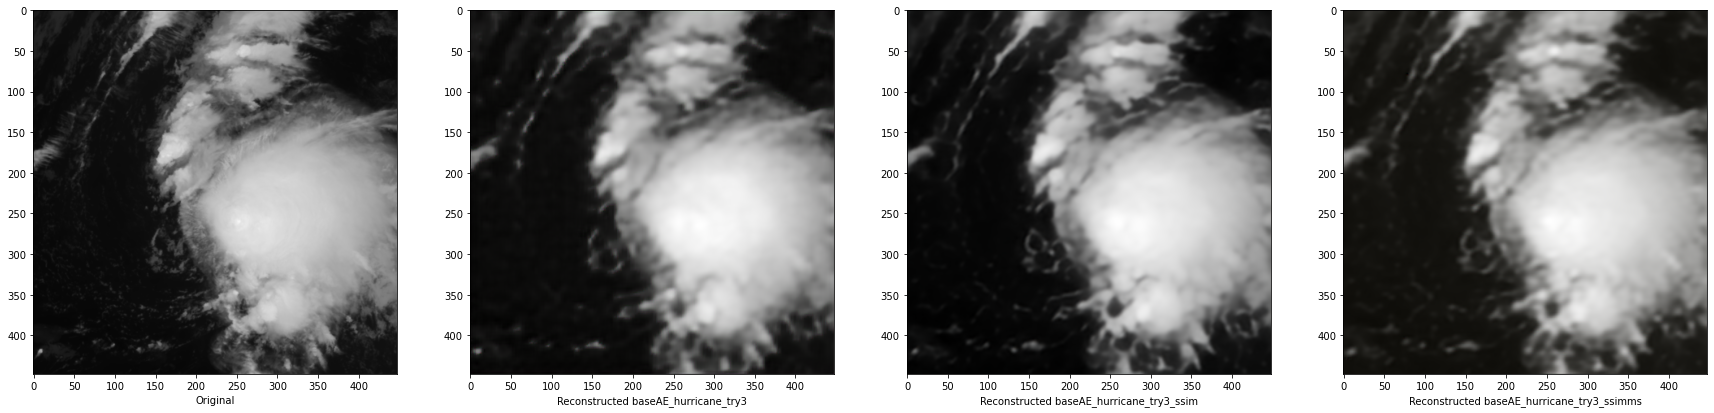

(1, 448, 448, 3)
Orig  0.0352945 0.9380125
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


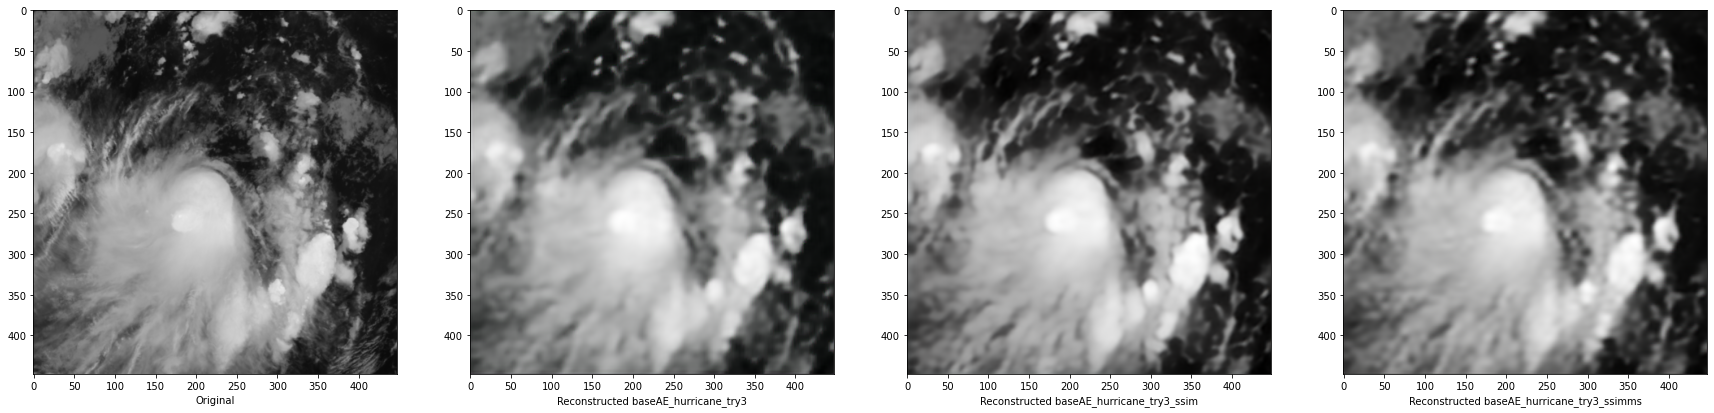

(1, 448, 448, 3)
Orig  0.1254902 0.87785053
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


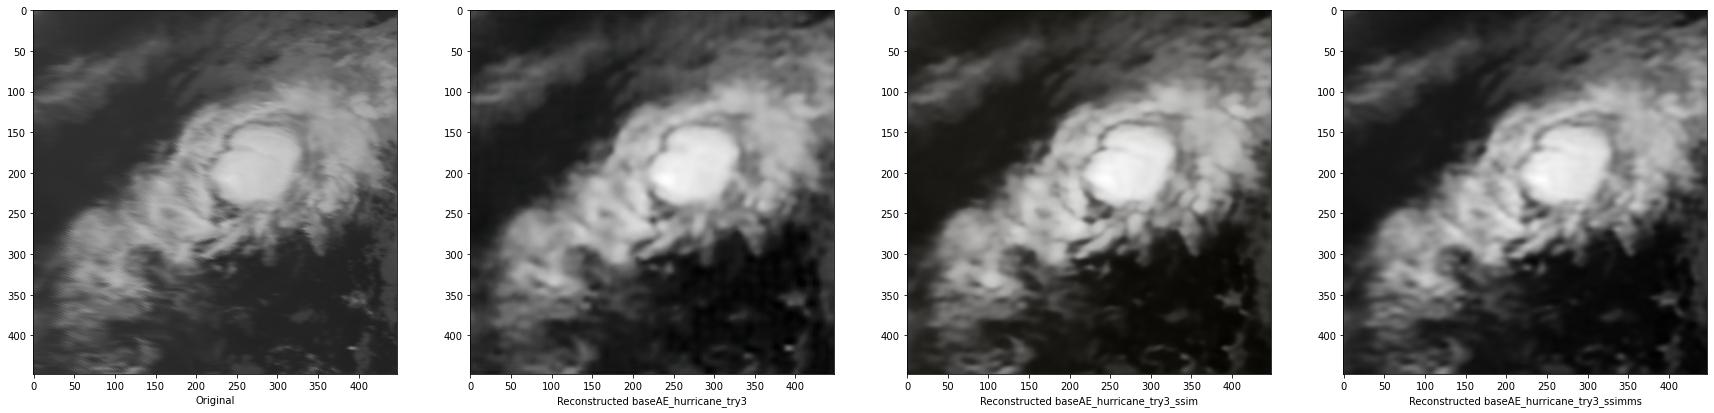

(1, 448, 448, 3)
Orig  0.05490606 0.89410186
baseAE_hurricane_try3 0.0 1.0
baseAE_hurricane_try3_ssim 0.0 1.0
baseAE_hurricane_try3_ssimms 0.0 1.0


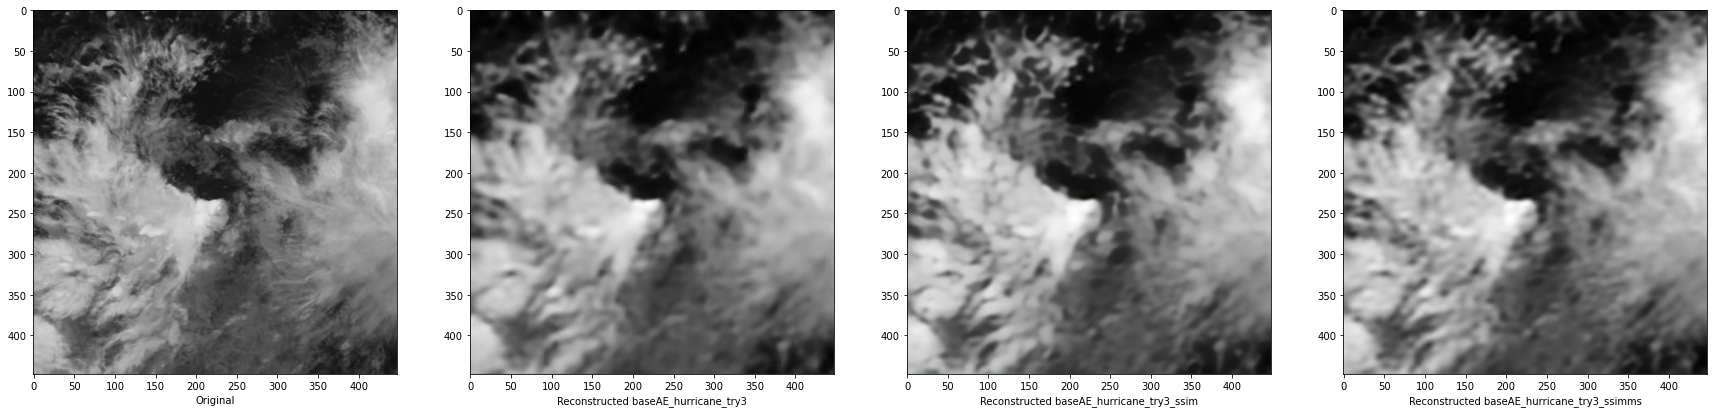

In [5]:
cust_obj_dict = {"baseAE_hurricane_try3_ssim": ('ssim_loss', aeh.ssim_loss), 
                 "baseAE_hurricane_try3_ssimms": ('ssim_loss_ms', aeh.ssim_loss_ms)}

model_names = ["baseAE_hurricane_try3", "baseAE_hurricane_try3_ssim", "baseAE_hurricane_try3_ssimms"]
num_models = len(model_names)
# custom_objects_bool = [False, True, True]

dims = (448, 448, 3)

DATA_PATH = "/home/satyarth934/data/nasa_impact/hurricanes/*/*"
# Dataloader creation and test
img_paths = glob.glob(DATA_PATH)
print("len(img_paths):", len(img_paths))

train_split = 0.6
valid_split = 0.2
test_split = 0.2
X_train_paths = img_paths[:int(train_split * len(img_paths))]
X_valid_paths = img_paths[int(train_split * len(img_paths)):int((train_split + valid_split) * len(img_paths))]
X_test_paths = img_paths[len(img_paths) - int(test_split * len(img_paths)):]

# complete_models = [None] * num_models

# for i in range(num_models):
#     MODEL_NAME = model_names[i]
#     OUTPUT_MODEL_PATH = "/home/satyarth934/code/FDL_2020/Models/" + MODEL_NAME

#     cust_obj_label = None if MODEL_NAME not in cust_obj_dict else cust_obj_dict[MODEL_NAME][0]
#     cust_obj_fn = None if MODEL_NAME not in cust_obj_dict else cust_obj_dict[MODEL_NAME][1]
#     complete_model[i] = load_model(OUTPUT_MODEL_PATH, custom_objects={cust_obj_label:cust_obj_fn})


# Plot N images and their reconstructions
N = 10
for i in range(N):
    index = np.random.randint(0, len(X_test_paths))
    img_orig = resize(plt.imread(X_test_paths[index])[:,:,:3], dims)
    X_test_im = np.expand_dims(img_orig, 0)
    print(X_test_im.shape)
    print("Orig ", np.min(X_test_im), np.max(X_test_im))
    
    fig = plt.figure(figsize=(30, 60))
    plt.subplot(1, num_models+1, 1)
    plt.xlabel("Original")
    plt.imshow(np.squeeze(X_test_im))

    for model_i in range(num_models):
        MODEL_NAME = model_names[model_i]
        OUTPUT_MODEL_PATH = "/home/satyarth934/code/FDL_2020/Models/" + MODEL_NAME

        cust_obj_label = None if MODEL_NAME not in cust_obj_dict else cust_obj_dict[MODEL_NAME][0]
        cust_obj_fn = None if MODEL_NAME not in cust_obj_dict else cust_obj_dict[MODEL_NAME][1]
        model = load_model(OUTPUT_MODEL_PATH, custom_objects={cust_obj_label:cust_obj_fn})
                                   
        out_image = np.squeeze(model.predict(X_test_im))
        
        im_min = out_image.min(axis=(0, 1), keepdims=True)
        im_max = out_image.max(axis=(0, 1), keepdims=True)
        out_image = (out_image - im_min) / (im_max - im_min)
        
        print(MODEL_NAME, np.min(out_image), np.max(out_image))
                                   
        plt.subplot(1, num_models+1, model_i+2)
        plt.xlabel("Reconstructed " + MODEL_NAME)
        plt.imshow(out_image)
        
    plt.savefig("reconstructed/%s/%d.png"%("baseAE_hurricane_comparison", i))
    plt.savefig("reconstructed/%s/%d.eps"%("baseAE_hurricane_comparison", i))
    plt.show()
